# **Analyzing VaR estimation accuracy in a portfolio of FAANG stocks using Bayesian Statistics**
## **Advanced Statistics - SA 2023-2024**
### Professor: Antonietta Mira | Assistant: Antonio Di Noia
### Student: Gian Marco Oddo - 22-992-952
#### gian.marco.oddo@usi.ch

---

## 1. R Requirements

### For this Notebook to work properly, R must be installed on your machine along with the 'rmgarch' package.

### Be sure to have the following set up:

- An active R environment.
- The 'rmgarch' package installed in your R environment.

### If you haven't set this up:

### 1. Download and install R

-  For macOS: https://cran.r-project.org/bin/macosx/
-  For Windows: https://cran.r-project.org/bin/windows/base/

### 2. Install the "rmgarch" package within your R environment.

#### - **For Mac or Linux you can use the following commands in the terminal**

```bash
R -e "install.packages('rmgarch', repos='https://cran.r-project.org')"
```

#### - Or you can do it on RStudio

> ### Here below a test script to see if R and the 'rmgarch' package are installed in the machine you are using.
> ### Run this code before starting the analysis please

In [1]:
def TestR():
    import subprocess
    def is_r_installed():
        try:
            subprocess.run(["R", "--slave", "--vanilla", "-e", "0"], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            return True
        except (subprocess.CalledProcessError, FileNotFoundError):
            return False
    def is_r_package_installed(package_name):
        try:
            cmd = ["R", "--slave", "--vanilla", "-e",
                f"if (!requireNamespace('{package_name}', quietly = TRUE)) quit(status=1, save = 'no')"]
            subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            return True
        except (subprocess.CalledProcessError, FileNotFoundError):
            return False
    if is_r_installed():
        print("R is installed on this machine.")
        if is_r_package_installed("rmgarch"):
            print("The 'rmgarch' package is installed within your R environment.")
        else:
            raise Exception("The 'rmgarch' package is not installed within your R environment. Please install it following the Requirements section above")
    else:
        raise Exception("R is not installed on this machine. Please install it following the Requirements section above")
TestR()

R is installed on this machine.
The 'rmgarch' package is installed within your R environment.


## 2. Python Requirements

This notebook relies on several Python packages, each with specific versions. Below is a list of the required packages and their respective versions:

- **pandas** (Version 2.0.1): Used for data manipulation and analysis.
- **numpy** (Version 1.26.2): Used for numerical operations and array handling.
- **yfinance** (Version 0.2.18): Used to fetch financial data from Yahoo Finance.
- **scikit-learn** (Version 1.3.0): Utilized for machine learning and data analysis tasks.
- **scipy** (Version 1.10.1): Used for scientific and statistical computing.
- **tqdm** (Version 4.66.1): Provides progress bars for loops and operations.
- **rpy2** (Version 3.5.13): Enables interaction with R within a Python environment.
- **matplotlib** (Version 3.8.0): Used for creating static, interactive, and animated visualizations.
- **seaborn** (Version 0.12.2): Enhances data visualization based on matplotlib.

Please ensure that these packages are installed in your Python environment and that they match the specified versions to ensure compatibility with this notebook.

#### - **You can use the following commands in the terminal**

```bash
pip install pandas==2.0.1 numpy==1.26.2 yfinance==0.2.18 scikit-learn==1.3.0 scipy==1.10.1 tqdm==4.66.1 rpy2==3.5.13 matplotlib==3.8.0 seaborn==0.12.2
```

---

## Introduction

FAANG is an acronym that represents some of the most prominent and high-performing technology companies listed on the American stock market: Facebook (now Meta Platforms), Apple, Amazon, Netflix, and Google (now Alphabet).

These businesses have been at the pioneering of technological innovation and have had a big impact on investment trends, consumer habits, and advancements in technology worldwide. 

Their equities are popular for having a large market capitalization, excellent growth potential, and having a significant impact on the direction of the stock market as a whole. 

Because of their market power, volatility, and position in the tech-driven economy, an analysis of the FAANG stocks is particularly interesting, from a risk perspective. 

This study examines how they behave together in a portfolio context, specifically assessing the potential effects of various variance-covariance matrix estimation techniques on the computation of the Value at Risk of an equally weighted portfolio formed each day for a two-year period.

## Objective of the study

Value at Risk (VaR) is a statistical metric used in finance to quantify the level of financial risk within an investment portfolio over a specific time frame.

It represents the maximum potential loss in value of a portfolio over a defined period for a given confidence interval. Essentially, VaR indicates the worst expected loss under normal market conditions within a specific time frame, such as a day or a year, at a certain confidence level.

This study presents a comprehensive Bayesian analysis of Value at Risk (VaR) for an equally weighted portfolio of FAANG stocks over a period of 504 days. The objective is to examine the precision and reliability of different variance-covariance matrix estimation methods in calculating the VaR. The methods employed include the Simple variance-covariance matrix, the Linear Shrinkage method (Ledoit and Wolf), the EWMA model for variances and covariances, and the DCC GARCH model. 

Each method offers a distinct perspective on capturing the dynamic risk characteristics of the portfolio.

In this analysis, the VaR is computed daily using each of the underlying methods for the variance-covariance matrix, based on one year's worth of data. This frequent recalibration allows for a detailed tracking of the evolving risk profile of the portfolio. 

The formula for Value at Risk (VaR) in the given context is expressed as follows:

$$
VaR = σ × q
$$

Where:
- **σ**: The standard deviation (in value) of the portfolio's returns, indicating risk or volatility.
- **q**: The z-score corresponding to the desired confidence level in a standard normal distribution. For a 95% confidence level, the z-score is approximately 1.645, implying a 95% probability that the portfolio's loss will not exceed the calculated VaR.

>  Note: This formula assumes a normal distribution of returns.

The calculation of **σ (Sigma)** is given by:

$$
\sigma = \sqrt{x \Sigma x^T}
$$

Where:
- **x**: The vector of value positions in the stocks

> Traditionally, it is expected that the actual losses would exceed the calculated VaR on a percentage of days equal to the chosen confidence level alpha. For example, with a 95% confidence level, the VaR should be exceeded on approximately 5% of the days.

> However, this study adopts a Bayesian approach, treating the proportion of VaR exceedances over 504 days as a binomial distribution. A prior beta distribution is established to represent initial beliefs about this proportion. As the study progresses, the actual number of exceedances observed and the total number of returns are used to update this distribution, yielding a posterior distribution that reflects updated beliefs based on the observed data.

> The Bayesian framework employed here allows for a nuanced and adaptive analysis. It not only tests the accuracy of the VaR calculations against real-world data but also provides insights into the effectiveness of different variance-covariance estimation methods. 

## Methods used to estimate the Variance Covariance Matrix $\Sigma$

#### 1. Simple Historical Method

This method involves calculating the historical covariance matrix.

Formula:

$$
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} (R_t - \bar{R})(R_t - \bar{R})^T
$$

Where:
- $R_t$ is the return at time $t$.
- $\bar{R}$ is the average return over the period.
- $T$ is the number of observations.

#### 2. Linear Shrinkage to the Identity Matrix (Ledoit-Wolf)

This method involves pulling the sample covariance matrix towards the identity matrix, which acts as the target or prior knowledge.

Formula:
$$
\Sigma_{shrink} = \rho I + (1 - \rho) \Sigma_{sample}
$$

Where:
- $\rho$ is the shrinkage intensity.
- $I$ is the identity matrix.
- $\Sigma_{sample}$ is the sample covariance matrix.

#### 4. EWMA Model

The Exponentially Weighted Moving Average (EWMA) model is used for estimating time-varying volatilities and correlations.

Formula:

$$
\sigma_{t,i}^2 = \lambda \sigma_{t-1,i}^2 + (1 - \lambda) r_{t,i}^2
$$

$$
\text{cov}_{i,j,t} = \lambda \text{cov}_{i,j,t-1} + (1 - \lambda) r_{t,i} r_{t,j}
$$

Where:
- $\lambda$ is the decay factor (0.94).
- $r_{t,i}$ and $r_{t,j}$ are the returns of assets assets $i$ and $j$ at time $t$, respectively.
- $\text{cov}_{i,j,t-1}$ is the covariance between assets $i$ and $j$ at time $t-1$.

#### 5. Dynamic Conditional Correlation (DCC) GARCH

The DCC GARCH model is used for modeling time-varying correlations in volatility.

Formula:

$$
Q_t = (1 - \alpha - \beta)\bar{Q} + \alpha (\epsilon_{t-1}\epsilon_{t-1}^T) + \beta Q_{t-1}
$$

Where:
- $\alpha$, $\beta$ are parameters estimated from the model.
- $\epsilon_{t-1}$ are the residuals from the GARCH model at time $t-1$.
- $\bar{Q}$ is the long-run average correlation matrix.

## Components of the the Variance-Covariance Matrix (VCM)


$$
\Sigma = \begin{pmatrix}
\sigma_1^2 & \text{cov}_{12} & \text{cov}_{13} & \cdots & \text{cov}_{1n} \\
\text{cov}_{21} & \sigma_2^2 & \text{cov}_{23} & \cdots & \text{cov}_{2n} \\
\text{cov}_{31} & \text{cov}_{32} & \sigma_3^2 & \cdots & \text{cov}_{3n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\text{cov}_{n1} & \text{cov}_{n2} & \text{cov}_{n3} & \cdots & \sigma_n^2
\end{pmatrix}
$$

**Variance $\sigma^2$**: The diagonal elements of the matrix ($\sigma^2$, $\sigma_2^2$, $\ldots$, $\sigma_n^2$) represent the variances of individual asset returns, indicating the degree of fluctuation in each asset's returns.

**Covariance (cov)**: The off-diagonal elements ($\text{cov}_{ij}$) represent the covariances between the returns of different assets, indicating how the returns of one asset move in relation to another.

## Importing all the needed modules

In [2]:
# Importing pandas for data manipulation
import pandas as pd

# Importing numpy for numerical operations
import numpy as np

# Importing yfinance for fetching financial data from Yahoo Finance
import yfinance as yf

# For representing the difference between two dates or times
from datetime import timedelta

# For robust covariance matrix estimation, useful in finance
from sklearn.covariance import LedoitWolf

# For operations related to the normal distribution
from scipy.stats import norm

# For displaying progress bars in loops
from tqdm import tqdm

# For general interaction with R within a Python environment
import rpy2.robjects as robjects

# For importing R packages in a Python environment
from rpy2.robjects.packages import importr

# For converting pandas DataFrame objects to R DataFrame objects
from rpy2.robjects import pandas2ri

# For creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

# For handling date formats in matplotlib plots
import matplotlib.dates as mdates

# For statistical data visualization based on matplotlib
import seaborn as sns

# Setting the style for seaborn plots to 'whitegrid'
sns.set_style("white")

# For handling warnings in Python code
import warnings

# To ignore warnings in Python, useful to keep the output clean
warnings.filterwarnings("ignore")

# Importing the Beta distribution for statistical operations
from scipy.stats import beta as beta_dist

## Support Functions for the VaR Calculation

In [3]:
def ewmaCondCov(returns, lambda_ewma):

    """
    Calculate the EWMA conditional covariance matrix for a set of returns.

    The function computes the exponentially weighted moving average (EWMA)
    variance for each asset and the covariance between each pair of assets.

    Parameters:
    - returns: A numpy array where each column represents the returns of one asset.
    - lambda_ewma: The decay factor for the EWMA calculation.

    Returns:
    - A numpy array representing the EWMA conditional covariance matrix.
    """
    
    # Convert the returns to a numpy array if not already one.
    returns = returns.values

    def ewma_cond_variance(rets, lambda_ewma):
        
        """
        Calculate the EWMA conditional variance for a single asset.

        Parameters:
        - rets: A numpy array of returns for a single asset.
        - lambda_ewma: The decay factor for the EWMA calculation.

        Returns:
        - The conditional variance for the next period (t+1).
        """
        # Initialize the variance time series with the variance of the first return.
        variance_time_series = np.repeat(rets[0]**2, len(rets))

        # Iterate over the returns to calculate EWMA variance for each time t.
        for t in range(1, len(rets)):
            variance_time_series[t] = lambda_ewma * variance_time_series[t-1] + (1-lambda_ewma) * rets[t-1]**2

        # Calculate and return the variance for the next period (t+1).
        variance_t_plus1 = lambda_ewma * variance_time_series[-1] + (1-lambda_ewma) * rets[-1]**2  
        return variance_t_plus1

    def ewma_cond_covariance(rets_1, rets_2, lambda_ewma):

        """
        Calculate the EWMA conditional covariance between two assets.

        Parameters:
        - rets_1: A numpy array of returns for the first asset.
        - rets_2: A numpy array of returns for the second asset.
        - lambda_ewma: The decay factor for the EWMA calculation.

        Returns:
        - The conditional covariance between the two assets for the next period (t+1).
        """
        # Initialize the covariance time series with the covariance of the first return.
        covariance_time_series = np.repeat(rets_1[0] * rets_2[0], len(rets_1))

        # Iterate over the returns to calculate EWMA covariance for each time t.
        for t in range(1, len(rets_1)):
            covariance_time_series[t] = lambda_ewma * covariance_time_series[t-1] + (1-lambda_ewma) * rets_1[t-1] * rets_2[t-1]

        # Calculate and return the covariance for the next period (t+1).
        covariance_t_plus1 = lambda_ewma * covariance_time_series[-1] + (1-lambda_ewma) * rets_1[-1] * rets_2[-1]
        return covariance_t_plus1
        
    # Initialize the covariance matrix with zeros.
    variance_cov_matrix = np.zeros((returns.shape[1], returns.shape[1]))

    # Calculate variance and covariance for each pair of assets.
    for i in range(returns.shape[1]):
        for j in range(returns.shape[1]):
            if i == j:
                # Diagonal elements are variances of individual assets.
                variance_cov_matrix[i, j] = ewma_cond_variance(returns[:, i], lambda_ewma=lambda_ewma)
            else:
                # Off-diagonal elements are covariances between different assets.
                variance_cov_matrix[i, j] = ewma_cond_covariance(returns[:, i], returns[:, j], lambda_ewma=lambda_ewma)

    # The covariance forecast matrix is the calculated covariance matrix.
    cov_forecast_np = variance_cov_matrix

    return cov_forecast_np

def dccCondCovGarch(returns, p, q):

    """
    Calculate the DCC-GARCH conditional covariance matrix for a set of returns.

    Args:
    - returns (np.array): A numpy array containing the returns data.
    - p (int): The lag order for the autoregressive (AR) part in the GARCH model.
    - q (int): The lag order for the moving average (MA) part in the GARCH model.

    Returns:
    - np.ndarray: The calculated conditional covariance matrix.

    This function uses the 'rmgarch' package in R to fit a DCC-GARCH model to the
    provided returns data. It returns the conditional covariance matrix forecast
    for the next time period: 1 day.
    """

    # Enable conversion between pandas dataframes and R dataframes
    pandas2ri.activate()

    # Import R's "base" and "rmgarch" package
    base = importr('base')
    rmgarch = importr('rmgarch')

    # Convert the returns DataFrame to R's dataframe format
    rets_df = pd.DataFrame(returns)
    rets_r = pandas2ri.py2rpy(rets_df)

    # Get the number of columns in the DataFrame (number of return series)
    num_cols = rets_df.shape[1]

    # R code string to fit the DCC-GARCH model
    r_code = """
    library(rmgarch)
    uspec <- ugarchspec(mean.model=list(armaOrder=c({},{})), variance.model=list(garchOrder=c({},{})))
    spec1 = dccspec(uspec=multispec(replicate({}, uspec)), dccOrder=c({},{}), distribution="mvnorm")
    fit1 <- dccfit(spec1, data={})
    forecast <- dccforecast(fit1, n.ahead = 1)
    cov_forecast <- forecast@mforecast$H[[1]]
    residuals <- residuals(fit1)
    """.format(p, q, p, q, num_cols, p, q, 'rets_r')

    # Assign the returns DataFrame to the R environment and execute the R code
    robjects.r.assign('rets_r', rets_r)
    robjects.r(r_code)

    # Retrieve the forecasted covariance matrix from R's output
    cov_forecast = robjects.r['cov_forecast'] 

    # Convert the covariance matrix to a NumPy array
    cov_forecast_np = np.array(cov_forecast).squeeze()

    return cov_forecast_np

def generate_beta_distributions(expected_value, variance):

    """
    This function calculates the alpha and beta parameters for a Beta distribution, given a specified
    expected value (mean) and variance. It uses the relationship between the mean, variance, 
    and the alpha and beta parameters of the Beta distribution.

    Parameters:
    - expected_value: A float representing the expected value (mean) of the Beta distribution.
    - variance: A float representing the variance of the Beta distribution.

    Returns:
    - alpha_prior: The calculated alpha parameter for the Beta distribution.
    - beta_prior: The calculated beta parameter for the Beta distribution.

    Note:
    The function assumes that the expected value and variance provided are valid for a Beta distribution,
    meaning that they fall within the permissible range for such distributions.
    """

    # Calculate a common term used in the computation of both alpha and beta parameters
    common_term = expected_value * (1 - expected_value) / variance - 1

    # Calculate the alpha parameter using the expected value and the common term
    alpha_prior = expected_value * common_term

    # Calculate the beta parameter using the expected value and the common term
    beta_prior = (1 - expected_value) * common_term

    return alpha_prior, beta_prior

def generate_posterior_beta_distributions(ones, n, variance, expected_value, credible_interval):
    """
    Generates the parameters for the posterior Beta distribution given observed data and calculates
    the credible interval.

    Parameters:
    ones (int): The number of successes (times VaR was exceeded).
    n (int): The total number of observations.
    variance (float): The variance of the prior Beta distribution.
    expected_value (float): The expected value (mean) of the prior Beta distribution.
    credible_interval (float): The credible interval for the posterior Beta distribution.

    Returns:
    tuple: A tuple containing:
        - alpha_posterior (float): The updated alpha parameter of the posterior Beta distribution.
        - beta_posterior (float): The updated beta parameter of the posterior Beta distribution.
        - (lower_bound, upper_bound) (tuple): The lower and upper bounds of the credible interval for the posterior Beta distribution.
    """

    # Calculating a common term used for initial alpha and beta parameters based on expected value and variance
    common_term = expected_value * (1 - expected_value) / variance - 1

    # Calculating initial alpha parameter of the Beta distribution
    alpha_prior = expected_value * common_term

    # Calculating initial beta parameter of the Beta distribution
    beta_prior = (1 - expected_value) * common_term

    # Updating the alpha parameter with the number of successes
    alpha_posterior = alpha_prior + ones

    # Updating the beta parameter with the number of failures
    beta_posterior = beta_prior + (n - ones)

    # Calculating the lower bound of the credible interval for the posterior Beta distribution
    lower_bound = beta_dist.ppf((1 - credible_interval) / 2, alpha_posterior, beta_posterior)

    # Calculating the upper bound of the credible interval for the posterior Beta distribution
    upper_bound = beta_dist.ppf(credible_interval + ((1 - credible_interval) / 2), alpha_posterior, beta_posterior)

    return alpha_posterior, beta_posterior, (lower_bound, upper_bound)

## FAANG Daily Retuns: from 2021-11-30 to 2023-12-02

In [4]:
# List of tickers for the FAANG Stocks
tickers = ["AAPL", "AMZN", "META", "NFLX", "GOOGL"]

# Downloading the data
data = yf.download(tickers, start="2021-11-30", end= "2023-12-02", progress= False)

# Calculating the daily returns
rets = data["Adj Close"].pct_change().dropna()

# Displaying the returns
rets

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2021-12-01,-0.003206,-0.018063,-0.005962,-0.042717,-0.037592
2021-12-02,-0.006130,-0.001847,0.013573,-0.000676,-0.002104
2021-12-03,-0.011724,-0.013839,-0.006746,-0.011437,-0.023261
2021-12-06,0.021503,0.011086,0.008123,0.035947,0.017538
2021-12-07,0.035446,0.027987,0.028742,0.015541,0.021038
...,...,...,...,...,...
2023-11-27,-0.000948,0.006747,-0.002048,-0.010437,-0.000813
2023-11-28,0.003214,-0.004738,0.005791,0.012817,-0.000355
2023-11-29,-0.005410,-0.004829,-0.016108,-0.020030,-0.003779


## Calculating the VaR Using Four Different Variance-Covariance Matrix Estimation Methods

In [5]:
# Selecting the level of confidence
alpha = 0.05

In [6]:
# Calculate the initial positions, equally weighted. Assuming 1000 dollars invested each day
positions = np.repeat(1/len(tickers), len(tickers)) * 1000

# Define the quantile for VaR calculation using the normal distribution
q = norm.ppf(1-alpha, loc=0, scale=1)

# Initialize arrays to store VaR values for different methods
SimpleVaRs, LedoitWolfVaRs, EwmaVaRs, DccGarchVaRs = (np.zeros(rets.shape[0]), 
                                                      np.zeros(rets.shape[0]), 
                                                      np.zeros(rets.shape[0]),
                                                      np.zeros(rets.shape[0]))

# Loop over each date in the returns dataset
for i in tqdm(range(rets.shape[0])):
    
    # Define the end and start date for the rolling window
    end_date = rets.index[i]
    start_date = end_date - timedelta(days=252)  # 252 trading days in a year

    # Download historical returns for the specified period
    retsVaR = yf.download(tickers, start=start_date, end=end_date, progress=False)["Adj Close"].pct_change().dropna()

    # Simple VaR Calculation

    # Calculate the covariance matrix of returns
    variance_cov_matrix = np.cov(retsVaR, rowvar=False)
    # Calculate portfolio variance
    SimpleVariancePort = np.dot(np.dot(positions, variance_cov_matrix), positions.T)
    # Standard deviation (sigma) of the portfolio
    sigma = np.sqrt(SimpleVariancePort)
    # Calculate VaR
    SimpleVaR = q * sigma

    # Ledoit-Wolf VaR Calculation

    # Fit the Ledoit-Wolf shrinkage model
    lw = LedoitWolf()
    lw.fit(retsVaR)
    # Get the shrunk covariance matrix
    shrinkage_cov_matrix = lw.covariance_
    # Calculate portfolio variance
    LedoitWolfVariance = np.dot(np.dot(positions, shrinkage_cov_matrix), positions.T)
    # Standard deviation (sigma) of the portfolio
    sigma = np.sqrt(LedoitWolfVariance)
    # Calculate VaR
    LedoitWolfVaR = q * sigma

    # EWMA VaR Calculation

    # Calculate the EWMA conditional covariance matrix
    ewma_cov_matrix = ewmaCondCov(retsVaR, 0.94)  # Assuming lambda = 0.94
    # Calculate portfolio variance
    EwmaVariance = np.dot(np.dot(positions, ewma_cov_matrix), positions.T)
    # Standard deviation (sigma) of the portfolio
    sigma = np.sqrt(EwmaVariance)
    # Calculate VaR
    EwmaVaR = q * sigma

    # DCC-GARCH VaR Calculation

    # Calculate the DCC-GARCH conditional covariance matrix
    dcc_cov_matrix = dccCondCovGarch(retsVaR.values, 1, 1) 
    # Calculate portfolio variance
    DccVariance = np.dot(np.dot(positions, dcc_cov_matrix), positions.T)
    # Standard deviation (sigma) of the portfolio
    sigma = np.sqrt(DccVariance)
    # Calculate VaR
    DccVaR = q * sigma

    # Store calculated VaR values
    SimpleVaRs[i] = SimpleVaR
    LedoitWolfVaRs[i] = LedoitWolfVaR
    EwmaVaRs[i] = EwmaVaR
    DccGarchVaRs[i] = DccVaR

100%|██████████| 504/504 [12:49<00:00,  1.53s/it]


## Plotting VaRs VS Actual Losses

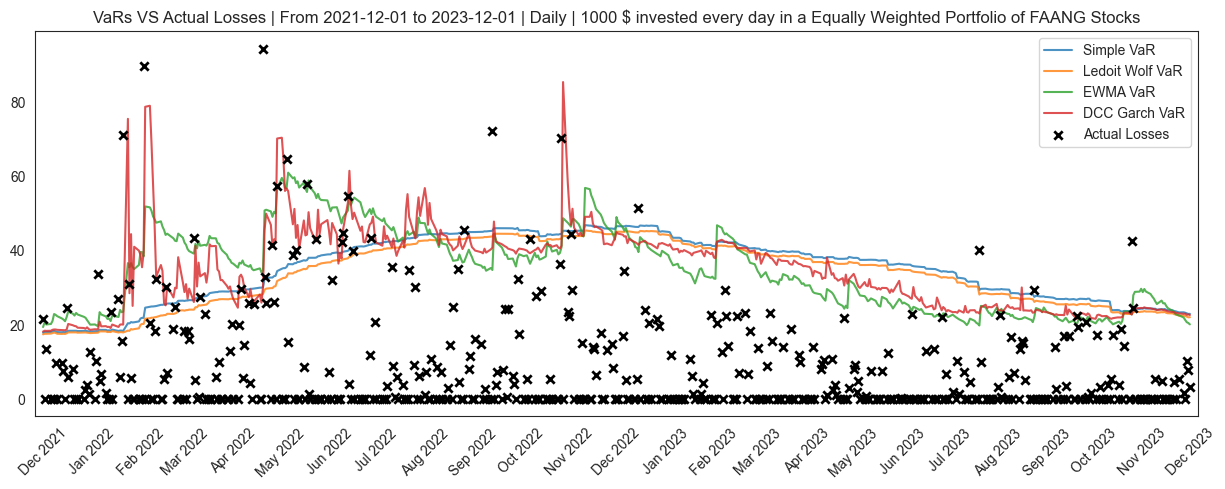

In [7]:
# Create a DataFrame to store Value at Risk (VaR) calculations and actual losses
VARS = pd.DataFrame({"Date": rets.index})
# Set 'Date' as the index of the DataFrame
VARS.set_index("Date", inplace=True)

# Calculate actual losses by dot product of daily returns and positions
# This gives the daily P&L for the portfolio
VARS["Actual Losses"] = np.dot(rets.values, positions.T)

# Filter only the losses (negative returns) for actual losses
# Positive returns are set to zero as they are not considered losses
VARS["Actual Losses"] = [value if value < 0 else 0 for value in VARS["Actual Losses"].values]

# Convert losses to positive values for comparison with VaR estimates
# VaR is expressed as a positive number, so we negate the losses
VARS["Actual Losses"] = [-1 * value for value in VARS["Actual Losses"]]

# Add the calculated VaR values from different methods to the DataFrame
VARS["Simple VaR"] = SimpleVaRs
VARS["Ledoit Wolf VaR"] = LedoitWolfVaRs
VARS["EWMA VaR"] = EwmaVaRs
VARS["DCC Garch VaR"] = DccGarchVaRs

# Plotting section
plt.figure(figsize=(15, 5))  # Set the size of the plot

# Plot each VaR calculation as a separate line
for column in VARS.columns:
    if column != "Actual Losses":
        plt.plot(VARS.index, VARS[column], label=column, alpha=0.8)

# Plot the actual losses as scatter points for clear visibility
plt.scatter(VARS.index, VARS["Actual Losses"], label="Actual Losses", color='black', zorder=3, marker="x", linewidths=2)

# Rotate and format the date labels on the x-axis for readability
plt.xticks(rotation=45)

# Set the x-axis to display dates with a month granularity
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adjust x-axis limits to include a small buffer around the data range
plt.gca().set_xlim(VARS.index.min() - timedelta(days=5), VARS.index.max() + timedelta(days=5))

# Set the plot title with the date range of the analysis
plt.title(f"VaRs VS Actual Losses | From {str(VARS.index[0])[0:10]} to {str(VARS.index[-1])[0:10]} | Daily | 1000 $ invested every day in a Equally Weighted Portfolio of FAANG Stocks",)

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


## Generating the "VaR Exceeded" Indicator by Comparing Calculated VaRs with Actual Losses

In [8]:
# Identify all columns in the VARS DataFrame that are related to VaR calculations
# It searches for columns that contain the substring 'VaR' in their names
var_columns = [col for col in VARS.columns if 'VaR' in col]

# Loop through each of the identified VaR columns
for col in var_columns:
    
    # Create a new column for each VaR calculation to indicate if the VaR was exceeded
    # This is done by comparing the VaR estimate with the actual losses
    # If the VaR estimate is less than the actual loss, it means the loss exceeded the VaR
    # The result is a boolean value (True/False), which is then converted to an integer (1/0)
    # '1' indicates that the VaR was exceeded, and '0' indicates it was not

    VARS[col + ' Exceeded'] = (VARS[col] < VARS['Actual Losses']).astype(int)

# Display the updated DataFrame
VARS

,Actual Losses,Simple VaR,Ledoit Wolf VaR,EWMA VaR,DCC Garch VaR,Simple VaR Exceeded,Ledoit Wolf VaR Exceeded,EWMA VaR Exceeded,DCC Garch VaR Exceeded
Date,,,,,,,,,
2021-12-01,21.508088,17.763254,17.315721,19.274203,18.058862,1,1,1,1
2021-12-02,-0.000000,17.924386,17.481633,20.598412,18.288644,0,0,0,0
2021-12-03,13.401683,17.916057,17.472447,19.972347,18.243598,0,0,0,0
2021-12-06,-0.000000,17.961526,17.519585,20.102513,18.273812,0,0,0,0
2021-12-07,-0.000000,18.073703,17.637032,20.916300,18.537467,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2023-11-27,1.499863,23.241770,22.370576,21.853799,22.836348,0,0,0,0
2023-11-28,-0.000000,23.134814,22.255279,21.196560,22.884371,0,0,0,0
2023-11-29,10.031016,22.985071,22.089639,20.595656,22.553774,0,0,0,0


## Summing up togheter the single Bernulli Random Variables to come up with the Binomial Distribution

In [9]:
# Extracting column names containing 'VaR Exceeded' from the DataFrame 'VARS'
var_exceeded_columns = [col for col in VARS.columns if 'VaR Exceeded' in col]

# Creating a list to store information for each model, including the model name
var_exceeded_list = []

# Iterating over columns that indicate VaR exceedances
for col in var_exceeded_columns:
    # Counting the total number of observations in the column
    total_count = VARS[col].count()

    # Counting the number of times VaR was exceeded (assuming '1' indicates exceedance)
    num_exceeded = VARS[col].sum()

    # Calculating the proportion of times VaR was exceeded
    proportion_exceeded = num_exceeded / total_count

    # Compiling the model's name and its exceedance details into a dictionary
    var_exceeded_list.append({
        "Model Name": col,
        "Total Count": total_count,
        "Number of Exceedances": num_exceeded,
        "Proportion of Exceedances": proportion_exceeded
    })

# Display the list containing information about each model's VaR exceedances
var_exceeded_list

[{'Model Name': 'Simple VaR Exceeded',
  'Total Count': 504,
  'Number of Exceedances': 33,
  'Proportion of Exceedances': 0.06547619047619048},
 {'Model Name': 'Ledoit Wolf VaR Exceeded',
  'Total Count': 504,
  'Number of Exceedances': 37,
  'Proportion of Exceedances': 0.07341269841269842},
 {'Model Name': 'EWMA VaR Exceeded',
  'Total Count': 504,
  'Number of Exceedances': 23,
  'Proportion of Exceedances': 0.04563492063492063},
 {'Model Name': 'DCC Garch VaR Exceeded',
  'Total Count': 504,
  'Number of Exceedances': 27,
  'Proportion of Exceedances': 0.05357142857142857}]

## The selected prior distribution for the frequency of VaR exceedances: the Beta Distribution

The Beta distribution is a versatile and widely used distribution in probability theory and statistics, particularly known for its application in Bayesian analysis. It is defined on the interval [0, 1] and is parameterized by two positive shape parameters, often denoted as α (alpha) and β (beta).

These parameters determine the shape of the distribution, making the Beta distribution flexible enough to represent a wide range of different probability distributions over a fixed interval.

##### Probability Density Function (PDF)
The probability density function (PDF) of the Beta distribution is given by:

$$
f(x; \alpha, \beta) = \frac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}
$$

where 
- **$B(\alpha, \beta)$** is the beta function, which serves as a normalization constant ensuring that the area under the PDF curve is 1.

##### Expected Value (Mean)
The expected value \( E(X) \) of a Beta-distributed random variable \( X \) with parameters \( \alpha \) and \( \beta \) is given by:
$$
E(X) = \frac{\alpha}{\alpha + \beta}
$$

##### Variance
The variance \( Var(X) \) of a Beta-distributed random variable \( X \) is given by:
$$
Var(X) = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}
$$


##### Conjugate Prior Property

One of the key properties of the Beta distribution in Bayesian analysis is that it is a conjugate prior. 

This means that if the prior distribution of a probability of success is a Beta distribution, and the likelihood is binomial (as is common in binary data scenarios), the posterior distribution is also a Beta distribution. This conjugacy simplifies the Bayesian updating process, making the Beta distribution particularly useful in sequential data analysis where evidence is accumulated over time.

In [10]:
# Given standard deviations from an expert
StandardDeviations = [0.025, 0.022, 0.015, 0.005]

### Rationale Behind Different Standard Deviations for VaR Estimation Methods

The specified standard deviations represent expert opinions on the portion of VaR exceedance for different variance-covariance estimation methods. These values are set in relation to alpha, the confidence level of the VaR calculation. The differences in these standard deviations reflect the varying capabilities and assumptions of each method in capturing the risk dynamics of a financial portfolio.

1. **Simple Historical Variance-Covariance Matrix (0.025)**: This method, with a standard deviation of 0.025, is a straightforward approach but does not account for volatility clustering. It assumes that historical volatilities and correlations are stable over time, which might not accurately reflect market realities.

2. **Ledoit and Wolf Shrinkage Method (0.022)**: This approach, with a slightly lower standard deviation of 0.022, improves upon the simple historical method by shrinking the extreme values in the variance-covariance matrix towards a central estimate. However, it still does not explicitly address volatility clustering.

3. **EWMA Model (0.015)**: The Exponentially Weighted Moving Average (EWMA) model, with a standard deviation of 0.015, accounts for volatility clustering by giving more weight to recent observations. This helps in capturing the changing volatility patterns but still operates under the assumption of a normal distribution for returns.

4. **DCC GARCH Model (0.005)**: The Dynamic Conditional Correlation (DCC) GARCH model, with the lowest standard deviation of 0.005, is the most sophisticated among the four. It not only addresses volatility clustering but also models the long-term correlations between different assets. 

The variance in standard deviations underscores the importance of model selection in VaR estimation. Models that account for volatility clustering and long-term correlations (like the EWMA and DCC GARCH) are perceived to be more accurate, as indicated by their lower standard deviations in the expert's assessment. 

> However, it's important to note that all these methods assume normality in the VaR calculation formula, which could be a limitation if the actual return distributions deviate from normality.

#### **These expert opinions, combined with the expected values of their respective Beta distributions, provide the foundational parameters (alpha and beta) for the initial prior distributions in the Bayesian analysis.** 

#### **This approach is crucial in establishing a well-informed starting point for the Bayesian inference process, allowing for a more nuanced understanding and prediction of VaR exceedances in the context of high-volatility portfolios such as those comprised of FAANG stocks.**

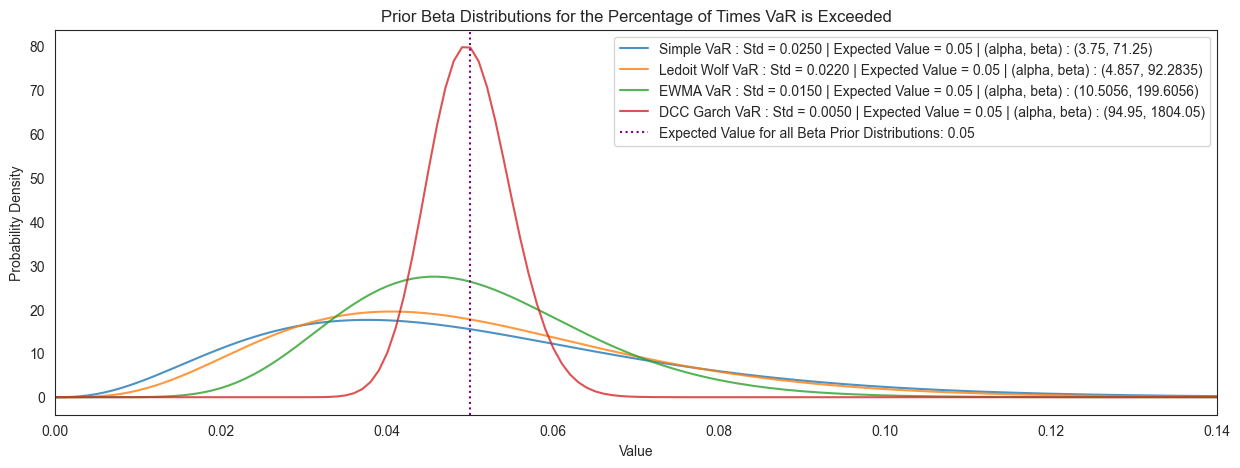

In [11]:
# Define the number of distributions to generate: Simple VaR, Ledoit Wolf VaR, Ewma VaR, and DCC Garch VaR
n = 4 

# Set the expected value (mean) for the Beta distributions
expected_value = alpha 

# Calculate the variances from the standard deviations
variances = [std ** 2 for std in StandardDeviations]

# Plotting section
plt.figure(figsize=(15, 5))  # Setting the size of the plot

# Define the range of x-values for plotting the Beta distributions
x = np.linspace(0, 1, 1000)

# Plot each Beta distribution for the given VaR models
for i in range(len(variances)):
    # Generate Beta distribution parameters (alpha and beta) for the given expected values and variances
    alpha_prior, beta_prior = generate_beta_distributions(expected_value, variances[i])

    # Compute the probability density function for the Beta distribution
    y = beta_dist.pdf(x, alpha_prior, beta_prior)

    # Plot the distribution, annotating with model name, standard deviation, expected value, and distribution parameters
    plt.plot(x, y, label=f'{var_exceeded_list[i]["Model Name"][:-9]} : Std = {np.sqrt(variances[i]):.4f} | Expected Value = {alpha} | (alpha, beta) : {(round(alpha_prior,4),round(beta_prior,4))}', alpha=0.8)

# Set the plot title, x-label, and y-label
plt.title('Prior Beta Distributions for the Percentage of Times VaR is Exceeded')
plt.xlabel('Value')
plt.ylabel('Probability Density')

# Draw a vertical line at the expected value for all distributions
plt.axvline(alpha, color='purple', linestyle=':', label=f'Expected Value for all Beta Prior Distributions: {alpha}')

# Limiting the x-axis range for better visualization of the distributions
plt.xlim((0, 0.14))

# Add a legend to the plot for easy identification of each distribution
plt.legend()

# Display the plot
plt.show()

## Posterior Distribution for the % of times VaR is exceeded: the core of the Bayesian Approach

In Bayesian analysis, the process of going from the prior distribution to the posterior distribution involves updating our beliefs about the parameters of interest after observing new data. This is done using Bayes' Theorem, which in the context of parameter estimation is typically written as:

$$
\text{Posterior}(\theta | data) \propto \text{Likelihood}(data | \theta) \times \text{Prior}(\theta)
$$

Where:
- $\text{Posterior}(\theta | data)$ is the probability distribution of the parameter $\theta$ after observing the data.
- $\text{Likelihood}(data | \theta)$ is the probability of the observed data under a given parameter value $\theta$.
- $\text{Prior}(\theta)$ is the probability distribution of the parameter $\theta$ before observing the data.
- $\propto$ denotes proportionality; to get the actual posterior distribution, we need to normalize this product so that it integrates to 1.

For the Beta distribution as a prior in the case of binomial data (such as VaR exceedances), the likelihood function for observing \( x \) successes out of \( n \) trials is given by the binomial distribution:

$$
\text{Likelihood}(x | n, p) = \binom{n}{x} p^x (1 - p)^{n - x}
$$

Here, $p$ represents the probability of success on each trial, which in the context of VaR would be the probability of exceedance.

If the prior distribution for $p $ is $\text{Beta}(\alpha, \beta)$, the posterior distribution after observing $x$ successes and $n - x$ failures is also a Beta distribution, specifically:

$$
\text{Posterior}(p | x, n) = \text{Beta}(\alpha + x, \beta + n - x)
$$

This reflects the conjugate prior property of the Beta distribution: the posterior parameters are simply the prior parameters updated by the number of successes and failures.

### Expected Value and Variance of the Posterior Distribution

The expected value $E(p)$ of the posterior Beta distribution is:

$$
E(p) = \frac{\alpha + x}{\alpha + \beta + n}
$$

The variance $text{Var}(p)$ of the posterior Beta distribution is:

$$
\text{Var}(p) = \frac{(\alpha + x)(\beta + n - x)}{(\alpha + \beta + n)^2(\alpha + \beta + n + 1)}
$$

### Credible Intervals vs Confidence Intervals

In Bayesian analysis, a credible interval provides the range within which an unobserved parameter value falls with a particular subjective probability. This is in contrast to confidence intervals used in frequentist statistics, which provide a range that would contain the parameter with a certain frequency if the experiment were repeated many times.

Credible intervals are derived directly from the posterior distribution and have a clear interpretation: the "95% credible interval" means there is a 95% probability that the parameter lies within this interval, given the observed data and the prior information.

On the other hand, a "95% confidence interval" in the frequentist context means that if we were to repeat the experiment many times and calculate the confidence interval each time, 95% of those intervals would contain the true parameter value. It does not assign a probability to the parameter being within a specific interval from one experiment.

This difference in interpretation stems from the fundamental distinction between Bayesian and frequentist approaches: Bayesian inference treats parameters as random variables with associated probability distributions, while frequentist inference treats parameters as fixed but unknown quantities.



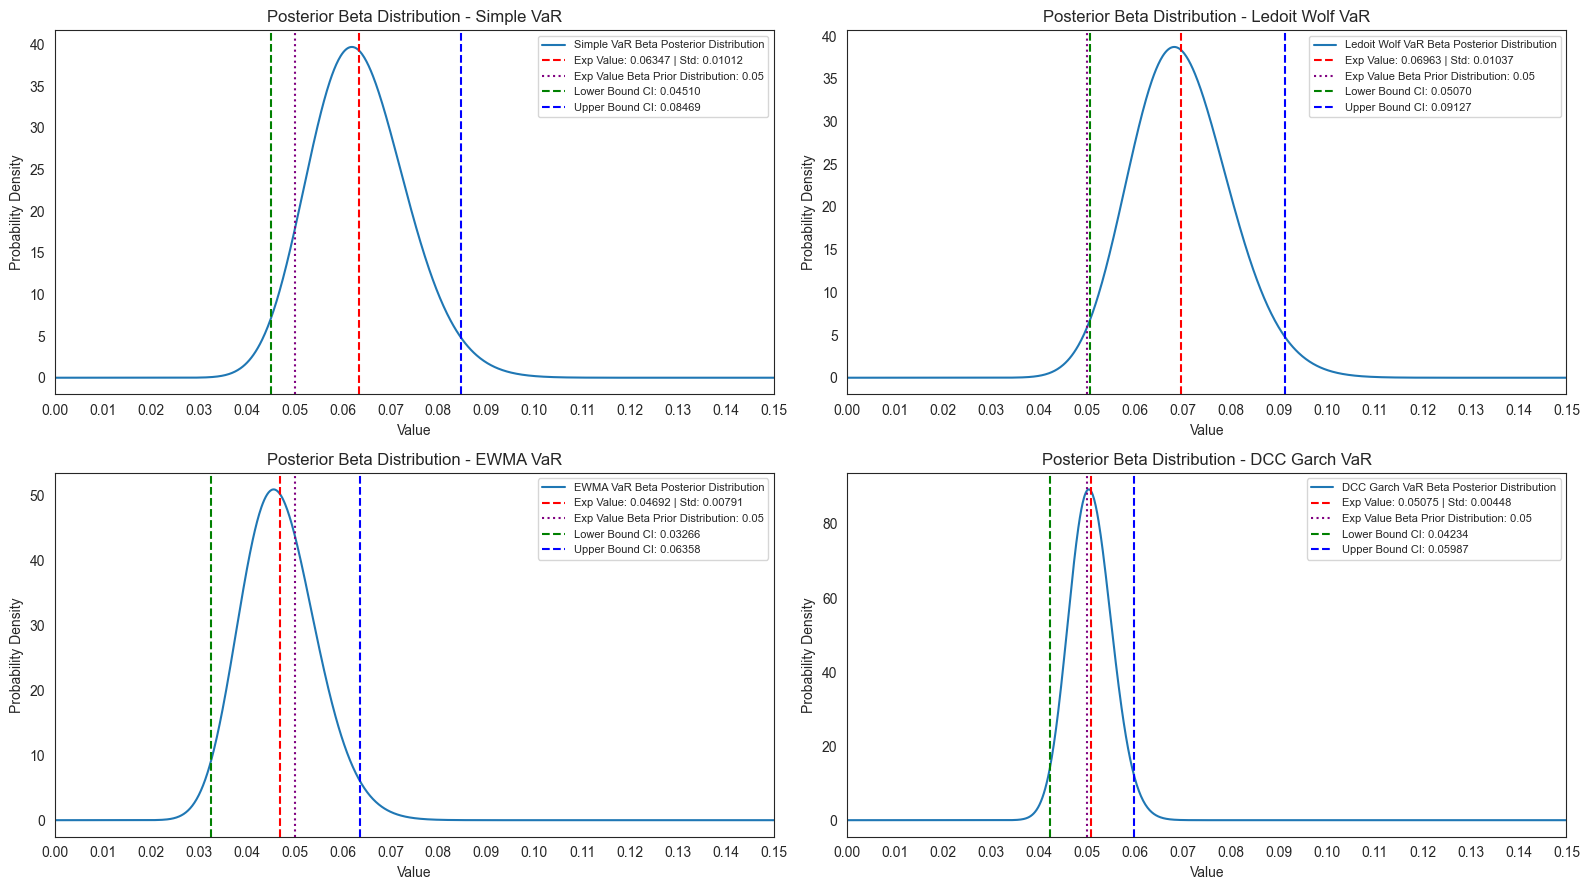

In [12]:
# Correcting the code by defining the credible_interval correctly
credible_interval = 0.95

# Re-running the plotting code with the credible interval included
fig, axs = plt.subplots(2, 2, figsize=(16, 9))  # Adjusted for a 2x2 grid
x = np.linspace(0, 0.15, 1000)  # Adjusted range for x values

for model, std in enumerate(StandardDeviations):
    variance = std ** 2
    ones = var_exceeded_list[model]["Number of Exceedances"]
    n = var_exceeded_list[model]["Total Count"]
    model_name = var_exceeded_list[model]["Model Name"][:-9]

    # Generate the posterior beta distributions and credible intervals
    alpha_posterior, beta_param_posterior, (lower_bound, upper_bound) = generate_posterior_beta_distributions(ones, n, variance, alpha, credible_interval)

    # Calculate the expected value and variance for the posterior distribution
    expected_value_posterior = alpha_posterior / (alpha_posterior + beta_param_posterior)
    posterior_variance = alpha_posterior * beta_param_posterior / ((alpha_posterior + beta_param_posterior)**2 * (alpha_posterior + beta_param_posterior + 1))

    # Determine the subplot to use
    ax = axs[model // 2, model % 2]

    # Plotting the Beta distribution
    y = beta_dist.pdf(x, alpha_posterior, beta_param_posterior)
    ax.plot(x, y, label=f'{model_name} Beta Posterior Distribution')

    ax.axvline(expected_value_posterior, color='r', linestyle='--', label=f'Exp Value: {expected_value_posterior:.5f} | Std: {np.sqrt(posterior_variance):.5f}')
    ax.axvline(alpha, color='purple', linestyle=':', label=f'Exp Value Beta Prior Distribution: {alpha}')

    # Plotting the credible interval
    ax.axvline(lower_bound, color='g', linestyle='--', label=f'Lower Bound CI: {lower_bound:.5f}')
    ax.axvline(upper_bound, color='b', linestyle='--', label=f'Upper Bound CI: {upper_bound:.5f}')

    # Set x-ticks to include alpha
    ax.set_xticks(np.arange(0, 0.16, 0.01))

    ax.set_title(f'Posterior Beta Distribution - {model_name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability Density')
    ax.legend(fontsize=8)
    ax.set_xlim(0, 0.15)  # Setting x-axis limit

# Adjusting layout for better visibility
plt.tight_layout()
plt.show()

## Results and Comments on the Posterior Beta Distributions

#### Simple VaR
- **Posterior Beta Distribution**: Indicates an increased belief in the probability of exceedance.
- **Expected Value**: `0.06347`
- **Standard Deviation**: `0.01012`
- **Lower Bound CI**: `0.04510`
- **Upper Bound CI**: `0.08469`

#### Ledoit Wolf VaR
- **Posterior Beta Distribution**: Strong update in exceedance probability.
- **Expected Value**: `0.06963`
- **Standard Deviation**: `0.01037`
- **Lower Bound CI**: `0.05070`
- **Upper Bound CI**: `0.09127`

#### EWMA VaR
- **Posterior Beta Distribution**: Shows a slight decrease in the estimation of the probability of exceedance.
- **Expected Value**: `0.04692`
- **Standard Deviation**: `0.00791`
- **Lower Bound CI**: `0.03266`
- **Upper Bound CI**: `0.06358`

#### DCC Garch VaR
- **Posterior Beta Distribution**: Closely aligns with prior, suggesting data confirms model's efficacy.
- **Expected Value**: `0.05075`
- **Standard Deviation**: `0.00448`
- **Lower Bound CI**: `0.04234`
- **Upper Bound CI**: `0.05987`

**The analysis yields a definitive outcome: the DCC GARCH model emerges as the superior method for estimating the Value at Risk (VaR). This conclusion is supported not only by prior beliefs, which favor the DCC GARCH model for its proficiency in capturing dynamic correlations and because it represents a weighted average of conditional correlation and last term trend, but also by empirical evidence.**

**Among the methods considered, the DCC GARCH model demonstrated the lowest variance, aligning with expert expectations and reinforcing its reliability as confirmed by the data. The expected value for the frequency of VaR exceedances is notably aligned with the VaR's alpha level, exemplifying the strength of the Bayesian approach in this context.**

**Furthermore, the credible interval obtained from the DCC GARCH model is the most precise compared to the others, offering a tighter and more confident range of the estimated parameter. Additionally, the standard deviation of the posterior distribution is the smallest of all four methods examined, indicating the highest level of precision in the estimates provided by the DCC GARCH model.**

**In summary, the DCC GARCH model's ability to closely predict the actual number of VaR exceedances and its robustness in terms of statistical confidence make it the optimal choice for risk estimation in this context.**

## Prior VS Posterior Beta Distributions - Visual Difference

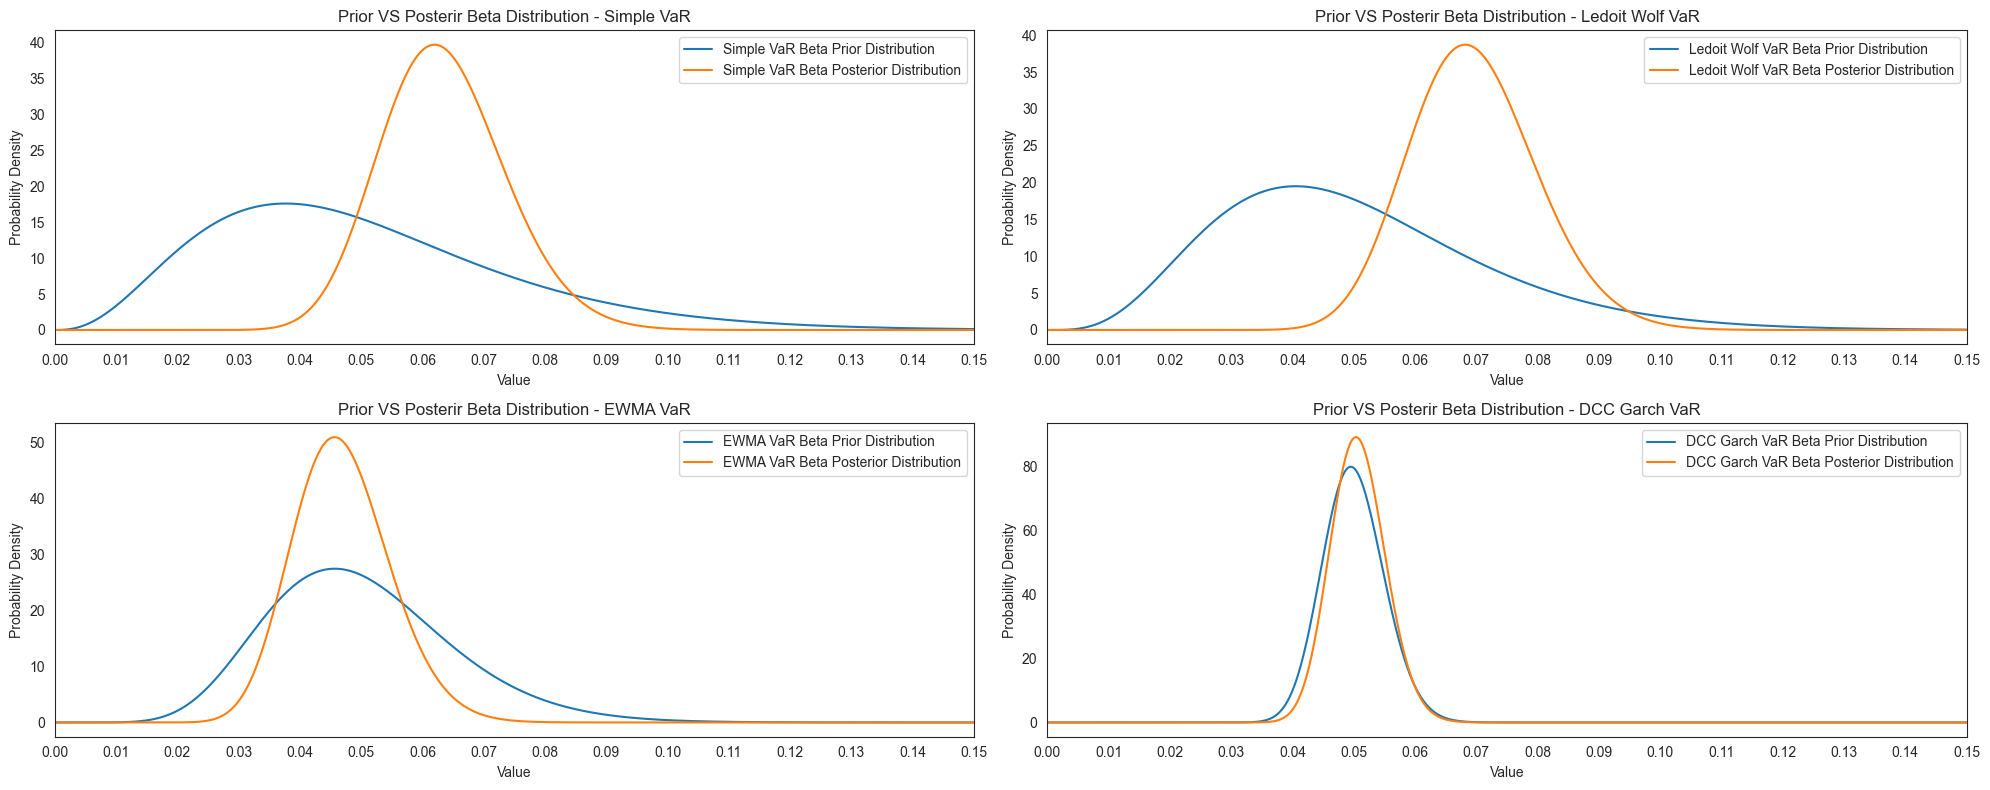

In [13]:
# Correcting the code by defining the credible_interval correctly
credible_interval = 0.95

# Re-running the plotting code with the credible interval included
fig, axs = plt.subplots(2, 2, figsize=(20, 8))  # Adjusted for a 2x2 grid
x = np.linspace(0, 0.15, 1000)  # Adjusted range for x values

for model, std in enumerate(StandardDeviations):
    variance = std ** 2
    ones = var_exceeded_list[model]["Number of Exceedances"]
    n = var_exceeded_list[model]["Total Count"]
    model_name = var_exceeded_list[model]["Model Name"][:-9]

    # Generate the prior beta distributions 
    alpha_prior, beta_prior = generate_beta_distributions(alpha,variance)

    # Generate the posterior beta distributions and credible intervals
    alpha_posterior, beta_param_posterior, (lower_bound, upper_bound) = generate_posterior_beta_distributions(ones, n, variance, alpha, credible_interval)

    # Calculate the expected value and variance for the posterior distribution
    expected_value_posterior = alpha_posterior / (alpha_posterior + beta_param_posterior)
    posterior_variance = alpha_posterior * beta_param_posterior / ((alpha_posterior + beta_param_posterior)**2 * (alpha_posterior + beta_param_posterior + 1))

    # Determine the subplot to use
    ax = axs[model // 2, model % 2]

    # Plotting the Beta distribution

    # Prior
    y_prior = beta_dist.pdf(x, alpha_prior, beta_prior)  
    ax.plot(x, y_prior, label=f'{model_name} Beta Prior Distribution')

    # Posterior
    y_post = beta_dist.pdf(x, alpha_posterior, beta_param_posterior)
    ax.plot(x, y_post, label=f'{model_name} Beta Posterior Distribution')


    # Set x-ticks to include alpha
    ax.set_xticks(np.arange(0, 0.16, 0.01))

    ax.set_title(f'Prior VS Posterir Beta Distribution - {model_name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability Density')
    ax.legend()
    ax.set_xlim(0, 0.15)  # Setting x-axis limit

# Adjusting layout for better visibility
plt.tight_layout()
plt.show()

## Results and Comments

#### Simple VaR

The prior distribution's peak is notably lower than the posterior's, indicating that the observed data suggest a higher probability of VaR exceedances than initially assumed. This considerable shift may imply that the Simple VaR method's initial model assumptions were conservative, or it did not fully capture the risk inherent in the data.


#### Ledoit Wolf VaR

The posterior distribution shifts to the right here as well, echoing the Simple VaR's findings but with a more pronounced movement. This suggests that the data did lead to a higher estimated probability of VaR exceedances.

#### EWMA VaR

The posterior shift is minimal to the left, which could indicate that the EWMA VaR's prior assumptions were more in line with the observed data. A lower posterior variance indicates that after accounting for the new data, there is increased certainty in the model's predictions. This increased precision implies that the model has a high degree of confidence in the estimated probability of VaR exceedances and suggests that the risk estimates provided by the EWMA VaR are reliable

#### DCC Garch VaR

The posterior distribution's close alignment with the prior suggests that the data closely matched the initial model expectations, which may indicate a strong fit of the DCC Garch model. This minimal shift signifies that the model, with its dynamic nature, was likely accurate in capturing the underlying risk from the start.

### Interpretation of Distribution Shifts

A shift in the peak from the prior to the posterior distribution represents an update in belief about the probability of VaR exceedances after considering new data. The extent of this shift is telling of how the new data affect prior beliefs:

- A large shift might indicate that the original model was not fully capturing the risk, prompting a significant update in the probability assessment.
- A minimal shift suggests that the observed data were well anticipated by the model, which might not necessitate substantial changes to the risk estimation.

**The DCC GARCH VaR model, among the four tested, stands out for its remarkable reliability. Its close alignment with the 5\% alpha level demonstrates that the observed data further supports the initial expert opinion. This convergence, achieved through a Bayesian approach, makes it particularly effective for estimating the Value at Risk.**

---

## Reference

1. Olivier Ledoit and Michael Wolf, "Honey, I Shrunk the Sample Covariance Matrix." Equities Division, Credit Suisse First Boston, London, UK, and Department of Economics and Business, Universitat Pompeu Fabra, Barcelona, Spain. November 2003.
2. Elisabeth Orskaug, "Multivariate DCC-GARCH Model - With Various Error Distributions." Master of Science Thesis, Department of Mathematical Sciences, Norwegian University of Science and Technology. Supervisor: Håvard Rue, MATH; Co-supervisor: Kjersti Aas, Norsk Regnesentral. June 2009.
3. Axel A. Araneda, "Asset volatility forecasting: The optimal decay parameter in the EWMA model." Institute of Financial Complex Systems, Faculty of Economics and Administration, Masaryk University, Brno, Czech Republic.
4. Weiqian Li, "Value at Risk (VaR) and its calculations: an overview." Instructor: Wenqing Hu, MATH 4997W, Date: 04/25/2016.
